DINAMICA MOLECULAR DE PROTEINAS USANDO MODELOS DE GO CON PROTEINAS REPRESENTADAS POR SUS Ca.

Estudiar el plegado del PDB ID 1ekg

Utilizando los modulos presentes en esta planilla realizar las siguientes tareas:

1) Realizar dinamicas de calentado y enfriado (20 10^6 pasos).

2) Graficar Q vs tiempo y Q vs temperatura. Puede elegir su definicion de contacto y escribirla siguiendo el modelo escrito abajo. Una vez que termina la simulacion puede calcular los contactos de cada cuadro de la trayectoria simulada. Se anima a implementar el calculo de contactos durante la dinamica ?

3) Determinar temperatura de plegado. Como lo haria ? Temperatura de plegado: es la cual tiene a los estados mas representativos en igualdad de probabilidad (dG = 0). 

4) Realizar 5 simulaciones a temperatura constante alrededor de la temperatura de plegado. Que espera ver en cuanto a los contactos nativos ?

5) Calcular Q vs tiempo a cada temperatura. 

6) Evaluar cambios en algunas helices y hebras beta, en cuanto a ángulos diedros. Comparar con el grafico de Ramachandran (opcional).

7) Calcule la keq usando Q/Qtot a diferentes T. Transforme en deltaG (-RT ln Keq).

Unidades reducidas

kT = Tr

si Tr = 1, kT = 1 y k = 0.008314 kJ/(K mol), entonces:

T = Tr/k
T = 1 / 0.008314
T = 120

si la T en openmm = 120, la T en unidades reducidas (Tr) = 1

In [24]:
############################################3

In [25]:
%reset -f

In [26]:
from openmm.app import *
from openmm import *
from openmm.app import PDBFile
from pdbfixer import PDBFixer
import numpy as np
import mdtraj as md
from simtk.openmm import CustomBondForce
from simtk.unit import *
from sys import stdout
import random as rd
import matplotlib.pylab as plt
%matplotlib inline

In [27]:
#### Archivos de entrada y salida

In [31]:
forcefield = ForceField("cg.xml")
file="1ekg_cleaned.pdb"
file2="ca_only.pdb"
inpdb = "1ekg.pdb"

outcleaned = file
outca = file2

In [29]:
#### Me quedo con los CA

In [32]:
fixer = PDBFixer(inpdb)
fixer.removeHeterogens(keepWater=False)
PDBFile.writeFile(fixer.topology, fixer.positions, open(outcleaned, 'w'))

pdb = md.load(outcleaned)
keep_list = []
for atom in pdb.topology.atoms:
    if atom.name == "CA":
        keep_list.append(atom.index)
chosen = pdb.atom_slice(keep_list)
chosen.save(outca)

In [33]:
##############Definicion de contactos 

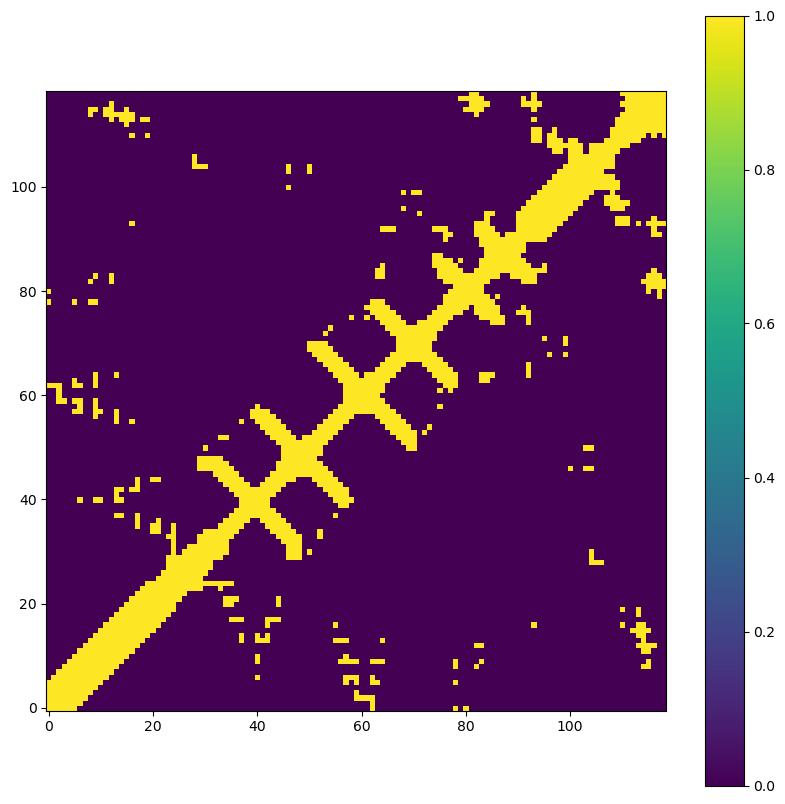

In [54]:
pdb = PDBFile(outca)
pos = pdb.positions.value_in_unit(nanometers)
pos = np.array(pos)
dis = (((pos.reshape(1, -1, 3) - pos.reshape(-1, 1, 3))**2).sum(axis=-1))**0.5

n = dis.shape[0]
contact_threshold = 0.95
contact_list = []
parameter2_list= []

for i in range(n):
    for j in range(i+3, n):
        dis_ij = round(dis[i][j],3)
        if dis_ij < contact_threshold:
            parameter2_list.append((dis_ij))
            contact_list.append((i, j))
            
plt.figure(figsize=[10,10])
plt.imshow(dis < contact_threshold, origin="lower")
plt.colorbar()

In [7]:
##################Campo de Fuerzas de tipo Go

In [8]:
from openmm import HarmonicBondForce

def ca_bonds(system, enlaces, k_con):
    con=HarmonicBondForce()
    n=system.getNumParticles()
    for i in range(n-1):
        con.addBond(i,i+1,enlaces[0][i],k_con)
    return con

In [9]:
from openmm import HarmonicAngleForce

def angle_term(system, angulos, k_ang):
    ang=HarmonicAngleForce()
    n=system.getNumParticles()
    for i in range(n-2):
        ang.addAngle(i,i+1,i+2,angulos[0][i],k_ang)
    return ang

In [10]:
from openmm import CustomTorsionForce

def dihedral_term(system, dihedrals, k_dih):
    k_dih=1*(kilojoule_per_mole/radian)
    dih=CustomTorsionForce("k_dih*(1-cos(theta-theta0))+0.5*k_dih*(1-cos(3*(theta-theta0)))")   
    dih.addPerTorsionParameter("k_dih")
    dih.addPerTorsionParameter("theta0")
    n=system.getNumParticles()
    for i in range(n-3):
        dih.addTorsion(i,i+1,i+2,i+3, [k_dih, dihedrals[0][i]])

    return dih

In [11]:
from openmm import CustomBondForce

def structure_based_term2(contact_list, parameter_list, ksb):
    ksb = 1
    structure_based = CustomBondForce(f"{ksb}*((5*((r_ijN/r)^(12))) - (6*((r_ijN/r)^(10))))")
    structure_based.addPerBondParameter("ksb")
    structure_based.addPerBondParameter("r_ijN")
    
    for contact, parameters in zip(contact_list, parameter2_list):
        structure_based.addBond(*contact, [ksb*kilojoule_per_mole, parameters])
    return structure_based

In [12]:
from openmm import CustomBondForce

def exclusion_term(contact_list, kex):
    kex = 1.0  
    exclusion_based = CustomBondForce(f"{kex}*((0.4/r)^(12))")
    exclusion_based.addPerBondParameter("kex")
    n=system.getNumParticles()
    for i in range(n):
        for j in range(i + 3, n):
            pair = (i, j)
            if pair not in contact_list:  
                exclusion_based.addBond(i, j, [kex*kilojoule_per_mole])

    return exclusion_based

In [13]:
##### Calculo de contactos de la trayectoria de dinámica molecular

In [14]:
def Qcalc(eps, contact_list, parameter_list, gamma):
    N = len(contact_list)
    Qs = CustomBondForce(f"1/{N}*eps*0.5*(1-tanh(gamma*(r-1.2*r_ijN)))")
#     Qs.addGlobalParameter("N",N)
    Qs.addGlobalParameter("gamma",gamma)
    Qs.addPerBondParameter("eps")
    Qs.addPerBondParameter("r_ijN")
    for contact, parameters in zip(contact_list, parameter_list):
        Qs.addBond(*contact, [eps, parameters])
    Qs.setForceGroup(12)
    return Qs

In [15]:
##########Simulacion

In [16]:
#######Determinacion de enlaces, angulos y diedros nativos

import mdtraj as md
pdb = md.load_pdb(outca)
topology = pdb.topology
nca = len(list(topology.residues))

c=[]
for i in range(0,nca-1):
    j=i+1
    k=i+2
    bond_indices = i,j
    c.append(bond_indices)

a=[]
for i in range(0,nca-2):
    j=i+1
    k=i+2
    angle_indices = i,j,k
    a.append(angle_indices)

b=[]
for i in range(0,nca-3):
    j=i+1
    k=i+2
    l=i+3
    dihedral_indices = i,j,k,l
    b.append(dihedral_indices)

enlaces = md.compute_distances(pdb,c,periodic=False, opt=True)
angulos = md.compute_angles(pdb, a, periodic=False, opt=True)
dihedrals = md.compute_dihedrals(pdb, b, periodic=False, opt=True)

############Dinamica Molecular
### regular cutoff, connect, angles, dihedrals, contacts
pdb = PDBFile(file2)
system = forcefield.createSystem(pdb.topology, nonbondedMethod=CutoffNonPeriodic, nonbondedCutoff=2.1*nanometers)
system.removeForce(0)
connect = ca_bonds(system, enlaces, 20000)
system.addForce(connect)
connect.setForceGroup(1)
angulos = angle_term(system, angulos, 40)
system.addForce(angulos)
angulos.setForceGroup(2)
torsions = dihedral_term(system, dihedrals, 1)
system.addForce(torsions)
torsions.setForceGroup(3)
structure_based = structure_based_term2(contact_list, parameter2_list, 1)
system.addForce(structure_based)
structure_based.setForceGroup(4)
exclusion = exclusion_term(contact_list, 1)
system.addForce(exclusion)
exclusion.setForceGroup(5)

In [17]:

integrator = LangevinIntegrator(125*kelvin, 1/picosecond, 0.0005*picoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy()
# simulation.reporters.append(DCDReporter("test3.dcd", 1000, append=False))
# simulation.reporters.append(PDBReporter("test3.pdb", 1000))
simulation.reporters.append(StateDataReporter(stdout, 1, step=True,
                                              potentialEnergy=True, temperature=True))
simulation.step(1000000)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1,-2203.9450925196566,0.12854387545272225
2,-2203.9347480359856,0.2468851478222473
3,-2203.9123809837106,0.3672986282193769
4,-2203.874216414288,0.46472580593887436
5,-2203.8174466389596,0.5628817798133832
6,-2203.7378191337834,0.6785421650097245
7,-2203.6362247986162,0.7866781585476746
8,-2203.511123189321,0.8644237888980464
9,-2203.368458969142,0.9474674573926294
10,-2203.206963684375,1.025571803362099
11,-2203.0293246283954,1.144393368041692
12,-2202.836317979055,1.213821334736073
13,-2202.625323608894,1.3038195475785856
14,-2202.4105809140497,1.3848315601960033
15,-2202.1861356742925,1.502664220558619
16,-2201.9483427057758,1.6139796455183932
17,-2201.709734228765,1.7115748987634858
18,-2201.471340753882,1.7731395427787522
19,-2201.2345257532006,1.8845992756413756
20,-2201.016764579098,1.9615263633524176
21,-2200.807839916596,2.0102097756065995
22,-2200.621849934058,2.1246296743555675
23,-2200.452609039345,2.173087318407179
24,

KeyboardInterrupt: 

In [ ]:
#####Simulated Annealing

Ti=200
nsteps=100000
outpdb = "lastconf.pdb"
out = "output.dcd"
data= "data.txt"
!rm {out}
integrator = LangevinIntegrator(Ti*kelvin, 1/picosecond, 0.0005*picoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy()
simulation.reporters.append(DCDReporter(out, 1, append=False))
simulation.reporters.append(StateDataReporter(data, 1, step=True,
                                              potentialEnergy=True, temperature=True))
simulation.step(1000)
for i in range(11):
    Tf = 1*(Ti-(10*i))
#     Tf = i
    savedcd = "out-fric2-"+str(Tf)+".dcd"
#     !rm {outpdb}
#     velmin=100000
#     velmax=1000000
    integrator = LangevinIntegrator(Tf*kelvin, 1/picosecond, 0.0005*picoseconds)## Ojo  2/picoseconds
    simulation = Simulation(pdb.topology, system, integrator)
    simulation.context.setPositions(pdb.positions)
    simulation.minimizeEnergy()
    simulation.context.setVelocitiesToTemperature(Tf,rd.randint(velmin, velmax))
    simulation.reporters.append(DCDReporter(savedcd, 10000, append=False))
    simulation.reporters.append(PDBReporter(outpdb, nsteps))
    simulation.reporters.append(StateDataReporter(stdout, 10000, step=True,
                                                  potentialEnergy=True, temperature=True))
    simulation.step(nsteps)
#     !cp {out} {savedcd}
    pdb = PDBFile(outpdb)